# artist-genre-evolution
This notebook is submitted as a prerequisite of CSMODEL and uses the [Million Song Dataset + Spotify + Last.fm Dataset](https://www.kaggle.com/datasets/undefinenull/million-song-dataset-spotify-lastfm/data) from Kaggle.

Our main goal is to answer the following research question:
### **"Do artists in certain music genres exhibit more change in their musical features over time than others?"**

In other words, we want to determine if an artist's genre influences how much their musical style (defined by features like `danceability`, `energy`, `acousticness`, etc.) evolves throughout their career.



## The Dataset
__________

### About the Dataset

This project utilizes the `Music_Info.csv` dataset of the wider merged dataset. This dataset is a curated collection of songs from Spotify.

The dataset is a rebuilt version and subset of  [The Million Song Dataset](http://millionsongdataset.com/). It was built up with  [lastfm-spotify-tags-sim-userdata](https://github.com/slettner/lastfm-spotify-tags-sim-userdata) ([The Echo Nest Taste Profile Subset](http://millionsongdataset.com/tasteprofile/) &  [lastfm-dataset-2020](https://github.com/renesemela/lastfm-dataset-2020)),  [tagtraum genre annotations](https://www.tagtraum.com/msd_genre_datasets.html), and  [Spotify API](https://developer.spotify.com/documentation/web-api). 

TODO: see if there are any further biases/implications by looking through the links

For each song, the dataset provides a rich set of attributes, including quantitative audio features derived from Spotify's audio analysis (e.g., danceability, energy, valence) and descriptive metadata (e.g., name, artist, year).

#### Data Collection & Potential Implications

The method of collection has several key implications for our analysis:

- **Source & Bias:** The data is sourced from Spotify, which means our insights will be specific to music available on that platform. The features are calculated by Spotify's proprietary algorithms, so we must rely on their definitions. The dataset may also have inherent biases (e.g., towards more popular, commercially successful music) which could influence our findings.
    - We are not studying the evolution of the "average" artist. We are studying the evolution of successful artists. The pressures of the commercial music industry (the need to produce hits, stay relevant, tour, etc.) might be a driving factor in why some genres evolve more than others.

- **Genre Ambiguity:** The original `genre` column is highly unreliable and often incorrect. The `tags` column provides a better, though unstructured, source for genre information. A significant part of our preprocessing will involve cleaning these tags to derive a meaningful genre for each artist or song-year combination. Furthermore, the `tags` column comes from user-generated tags - while we have indeed cleaned them, they still reflect a user-generated system rather than a strict musicological definition  -- TODO: pending verification, look through the tagtraum stuff to verify

- **Temporal Relevance**: The dataset represents a snapshot in time. Song popularity is highly dynamic, and the trends identified may be specific to the period in which the data was collected. (TODO: insert the time period of data its collected); The patterns of evolution we see might be specific to the modern music industry.

- **Western-Centric Bias** (Geographic Bias): The dataset is overwhelmingly dominated by artists from North America and Europe. Our conclusions are really about the evolution of artists within the Western music industry -- We cannot claim that these patterns hold true for music in Asia, Africa, or South America, as we simply don't have enough data.



#### Structure

- **Rows:** Each row represents a single song.
- **Columns:** Each column represents a specific attribute or feature of that song.
- **Observations:** The dataset contains over 50,000 songs.

## Step 1: Setup and Initial Data Load

We begin by importing the necessary Python libraries for data manipulation, analysis, and visualization. 

- **pandas:** For data structures and operations.
- **numpy:** For numerical operations.
- **matplotlib.pyplot & seaborn:** For creating visualizations.
- **sklearn.preprocessing.StandardScaler:** To standardize our numerical features later on.
- **scipy.stats:** For statistical tests.
- **sklearn.cluster.KMeans:** For clustering analysis.
- **collections.Counter:** To easily count tag frequencies.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import scipy.stats as stats
from collections import Counter

### 1.1. Load the Dataset

Next, we load the `Music_Info.csv` file into a pandas DataFrame. We'll then use `.info()` to get a summary of the data, including column names, data types, and non-null counts. We'll also use `.head()` to preview the first few rows and get a feel for the data's structure.

In [3]:
df = pd.read_csv('Music_Info.csv')
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50683 entries, 0 to 50682
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   track_id             50683 non-null  object 
 1   name                 50683 non-null  object 
 2   artist               50683 non-null  object 
 3   spotify_preview_url  50683 non-null  object 
 4   spotify_id           50683 non-null  object 
 5   tags                 49556 non-null  object 
 6   genre                22348 non-null  object 
 7   year                 50683 non-null  int64  
 8   duration_ms          50683 non-null  int64  
 9   danceability         50683 non-null  float64
 10  energy               50683 non-null  float64
 11  key                  50683 non-null  int64  
 12  loudness             50683 non-null  float64
 13  mode                 50683 non-null  int64  
 14  speechiness          50683 non-null  float64
 15  acousticness         50683 non-null 

,track_id,name,artist,spotify_preview_url,spotify_id,tags,genre,year,duration_ms,danceability,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,TRIOREW128F424EAF0,Mr. Brightside,The Killers,https://p.scdn.co/mp3-preview/4d26180e6961fd46...,09ZQ5TmUG8TSL56n0knqrj,"rock, alternative, indie, alternative_rock, in...",NaN,2004,222200,0.355,...,1,-4.360,1,0.0746,0.001190,0.000000,0.0971,0.240,148.114,4
1,TRRIVDJ128F429B0E8,Wonderwall,Oasis,https://p.scdn.co/mp3-preview/d012e536916c927b...,06UfBBDISthj1ZJAtX4xjj,"rock, alternative, indie, pop, alternative_roc...",NaN,2006,258613,0.409,...,2,-4.373,1,0.0336,0.000807,0.000000,0.2070,0.651,174.426,4
2,TROUVHL128F426C441,Come as You Are,Nirvana,https://p.scdn.co/mp3-preview/a1c11bb1cb231031...,0keNu0t0tqsWtExGM3nT1D,"rock, alternative, alternative_rock, 90s, grunge",RnB,1991,218920,0.508,...,4,-5.783,0,0.0400,0.000175,0.000459,0.0878,0.543,120.012,4
3,TRUEIND128F93038C4,Take Me Out,Franz Ferdinand,https://p.scdn.co/mp3-preview/399c401370438be4...,0ancVQ9wEcHVd0RrGICTE4,"rock, alternative, indie, alternative_rock, in...",NaN,2004,237026,0.279,...,9,-8.851,1,0.0371,0.000389,0.000655,0.1330,0.490,104.560,4
4,TRLNZBD128F935E4D8,Creep,Radiohead,https://p.scdn.co/mp3-preview/e7eb60e9466bc3a2...,01QoK9DA7VTeTSE3MNzp4I,"rock, alternative, indie, alternative_rock, in...",RnB,2008,238640,0.515,...,7,-9.935,1,0.0369,0.010200,0.000141,0.1290,0.104,91.841,4


## Step 2: Data Cleaning and Preprocessing

This is the most critical phase of our analysis. The raw dataset, while rich, has several issues that must be addressed to ensure the validity of our results. Our primary challenge is the unreliable `genre` column and the unstructured nature of the `tags` column.

### 2.1. Handling Missing Values and Data Types

First, we check for any missing data. The `genre` column has many missing values, but we will be replacing it with our own genre assignment logic, so we can ignore it. The `spotify_preview_url` and `spotify_id` columns also have missing values, but they are not relevant to our analysis. We will, however, convert the `year` column to a numeric type for proper sorting and grouping.

In [4]:
print(df.isnull().sum())

# Convert year to numeric, coercing errors to NaN (Not a Number)
df['year'] = pd.to_numeric(df['year'], errors='coerce')

# Drop rows where year or tags are missing
df.dropna(subset=['year', 'tags'], inplace=True)

# Convert year to integer
df['year'] = df['year'].astype(int)

track_id                   0
name                       0
artist                     0
spotify_preview_url        0
spotify_id                 0
tags                    1127
genre                  28335
year                       0
duration_ms                0
danceability               0
energy                     0
key                        0
loudness                   0
mode                       0
speechiness                0
acousticness               0
instrumentalness           0
liveness                   0
valence                    0
tempo                      0
time_signature             0
dtype: int64


### 2.2. Cleaning the `tags` Column

The `tags` column is our best source for genre information, but it's a comma-separated string containing many non-genre words (e.g., `'love'`, `'00s'`, `'british'`). Our process is as follows:

1.  **Convert String to List:** Split the comma-separated string into a list of tags.
2.  **Define Non-Genre Tags:** Create a comprehensive list of words to filter out. This includes subjective terms, decades, locations, and other noise.
3.  **Filter and Standardize Tags:** Create a new column, `cleaned_tags`, that contains only the relevant genre tags for each song, with subgenres standardized to their parent genres (e.g., `indie_rock` becomes `rock`).

In [5]:
# Function to split and strip whitespace from tags
def split_tags(s):
    if isinstance(s, str):
        return [tag.strip() for tag in s.split(',') ]
    return []

df['tags_list'] = df['tags'].apply(split_tags)

# Define a list of common non-genre tags to exclude
non_genre_tags = ['love', 'beautiful', 'mellow', 'chill', 'sad', 'happy', 'summer', 'party',
     'workout', 'studying', 'driving', 'classic', 'live', 'cover', 'soundtrack', 'instrumental',
     'male_vocalists', 'female_vocalists', 'british', 'american', 'swedish', 'german', 'french',
     'canadian', 'australian', 'irish', 'japanese', 'spanish', 'brazilian', 'italian', 'dutch',
     'norwegian', 'finnish', 'danish', 'polish', 'russian', 'uk', 'us', 'ie', 'ca', 'au', 'de', 'fr',
     'es', 'it', 'jp', 'nl', 'se', 'no', 'fi', 'dk', 'pl', 'ru', 'br', '60s', '70s', '80s', '90s',
     '00s', '10s', '20s', 'singer_songwriter', 'guitar', 'oldies', 'acoustic', 'piano', 'chillout',
     'lounge', 'downtempo', 'experimental', 'psychedelic', 'noise', 'avant_garde']

# Function to clean and filter tags
def clean_and_filter_tags(tags):
    if not isinstance(tags, list):
        return []
    # Standardize subgenres to parent genres
    processed_tags = []
    for t in tags:
        if 'rock' in t: processed_tags.append('rock')
        elif 'pop' in t: processed_tags.append('pop')
        elif 'metal' in t: processed_tags.append('metal')
        elif 'punk' in t: processed_tags.append('punk')
        elif 'hip_hop' in t: processed_tags.append('hip-hop')
        elif t not in non_genre_tags: processed_tags.append(t)
    return sorted(list(set(processed_tags))) # Use set to get unique tags for the song

df['cleaned_tags'] = df['tags_list'].apply(clean_and_filter_tags)

# Display the original vs. cleaned tags for a few rows to verify the fix
print(df[df['artist'] == 'The Killers'][['name', 'tags_list', 'cleaned_tags']].head())

                               name  \
0                    Mr. Brightside   
5                  Somebody Told Me   
20              When You Were Young   
38  All These Things That I've Done   
50           Smile Like You Mean It   

                                            tags_list  \
0   [rock, alternative, indie, alternative_rock, i...   
5   [rock, alternative, indie, pop, alternative_ro...   
20  [rock, alternative, indie, alternative_rock, i...   
38  [rock, alternative, indie, alternative_rock, i...   
50  [rock, alternative, indie, pop, alternative_ro...   

                       cleaned_tags  
0        [alternative, indie, rock]  
5   [alternative, indie, pop, rock]  
20       [alternative, indie, rock]  
38       [alternative, indie, rock]  
50  [alternative, indie, pop, rock]  


## Step 3: Assigning Genre by Artist and Year

This is the core of our improved methodology. Instead of assigning a single genre to an artist for their entire career, we will determine their most likely genre for each year. This allows us to track genre evolution accurately.

1.  **Group by Artist and Year:** We group the DataFrame by both `artist` and `year`.
2.  **Aggregate Tags:** For each artist-year group, we collect all the `cleaned_tags` from all songs in that year.
3.  **Find Most Common Genre:** We use `collections.Counter` to find the most frequent tag for that year. This becomes the `yearly_genre`.
4.  **Merge Back:** We merge this yearly genre information back into our main DataFrame.

In [6]:
# Group by artist and year, then aggregate all cleaned tags for that year
artist_year_tags = df.groupby(['artist', 'year'])['cleaned_tags'].sum().reset_index()

# Function to find the most common genre tag
def get_most_common_genre(tags):
    if not tags:
        return 'Unknown'
    # Count frequencies and return the most common one
    return Counter(tags).most_common(1)[0][0]

artist_year_tags['yearly_genre'] = artist_year_tags['cleaned_tags'].apply(get_most_common_genre)

# Merge the yearly_genre back into the main dataframe
df = pd.merge(df, artist_year_tags[['artist', 'year', 'yearly_genre']], on=['artist', 'year'], how='left')

# Display an example of an artist who has changed genres
print('David Bowie Genre Evolution:')
print(df[df['artist'] == 'David Bowie'][['year', 'name', 'yearly_genre']].drop_duplicates().sort_values('year'))

David Bowie Genre Evolution:
       year                                    name yearly_genre
23326  1967                    When I Live My Dream         rock
18239  1967                   Love You Till Tuesday         rock
1952   1976                            Golden Years          pop
6547   1976                                    Star          pop
10181  1993                               Blue Jean     new_wave
32822  1995                     Maid Of Bond Street         rock
22451  1995                The Hearts Filthy Lesson         rock
10721  1997                           Little Wonder         rock
18410  1997                             Rubber Band         rock
18419  1997                            Telling Lies         rock
32635  1997                            Uncle Arthur         rock
25583  1997                          Silly Boy Blue         rock
38238  1997                  Please Mr. Gravedigger         rock
18050  1999                            I'm Deranged  alternat

## Step 4: Filtering for Meaningful Analysis

To ensure our analysis of evolution is robust, we need to filter our dataset to include only artists with a sufficient body of work over a meaningful period.

1.  **Drop Song Duplicates:** Now that we have assigned genres, we can drop duplicate tracks (based on `track_id`) to ensure each song is counted only once in our feature analysis.
2.  **Filter Artists:** We will keep only artists who have at least 3 unique songs released across at least 2 different years. 

In [7]:
# changed since old one was pretty convoluted, this time i use super cool lambda functions and groupby

# Drop duplicate songs, keeping the first entry
df_unique_songs = df.drop_duplicates(subset='track_id', keep='first').copy()

# Calculate artist metrics for filtering
artist_stats = df_unique_songs.groupby('artist').agg(
    song_count=('track_id', 'nunique'),
    year_span=('year', lambda x: x.max() - x.min() if x.nunique() > 1 else 0)
).reset_index()

# Identify eligible artists
eligible_artists = artist_stats[(artist_stats['song_count'] >= 3) & (artist_stats['year_span'] >= 2)]['artist']

# Filter the main dataframe to include only these artists
df_final = df_unique_songs[df_unique_songs['artist'].isin(eligible_artists)].copy()

print(f'Original unique artists: {df_unique_songs["artist"].nunique()}')
print(f'Artists remaining after filtering: {len(eligible_artists)}')

Original unique artists: 8065
Artists remaining after filtering: 3213


## Step 5: Quantifying Musical Evolution

We quantify an artist's musical change using the Euclidean Distance. This measures the straight-line distance between two points in a multi-dimensional space. Here, a "point" is the average vector of an artist's musical features for a given year.

1.  **Select & Standardize Features:** We select the numerical audio features and standardize them using `StandardScaler`. This is crucial because features are on different scales (e.g., `loudness` vs. `danceability`), and standardization ensures they contribute equally to the distance calculation.
2.  **Calculate Yearly Averages:** For each artist, we group by year and compute the average for each musical feature.
3.  **Compute Euclidean Distance:** We calculate the distance between the feature vectors of consecutive years for each artist.
4.  **Average the Change:** The final `musical_change_score` for an artist is the average of these year-over-year distances.

In [8]:
musical_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                                'instrumentalness', 'liveness', 'valence', 'tempo']

# Standardize the features
scaler = StandardScaler()
df_final[musical_features] = scaler.fit_transform(df_final[musical_features])

artist_change_scores = {}
for artist in df_final['artist'].unique():
    artist_df = df_final[df_final['artist'] == artist].sort_values('year')
    yearly_avg_features = artist_df.groupby('year')[musical_features].mean()
    
    distances = []
    if len(yearly_avg_features) > 1:
        for i in range(1, len(yearly_avg_features)):
            vec1 = yearly_avg_features.iloc[i-1].values
            vec2 = yearly_avg_features.iloc[i].values
            distance = np.linalg.norm(vec1 - vec2)
            distances.append(distance)
            
    if distances:
        artist_change_scores[artist] = np.mean(distances)
    else:
        artist_change_scores[artist] = 0

# Create the final DataFrame for analysis
change_df = pd.DataFrame.from_dict(artist_change_scores, orient='index', columns=['musical_change_score'])
change_df.index.name = 'artist'

# For genre-based analysis, we assign a single primary genre to each artist (their most frequent one overall)
# This wasnt in the old code since it was previously done in an earlier cell, which was removed for a better structure and flow
primary_genres = df_final.groupby('artist')['yearly_genre'].agg(lambda x: x.mode()[0]).reset_index()
primary_genres.rename(columns={'yearly_genre': 'primary_genre'}, inplace=True)

analysis_df = pd.merge(change_df, primary_genres, on='artist')

print(analysis_df.head())

            artist  musical_change_score primary_genre
0      The Killers              1.720247   alternative
1            Oasis              1.385301           pop
2          Nirvana              2.614985   alternative
3  Franz Ferdinand              2.787395   alternative
4        Radiohead              2.132827   alternative


## Step 6: Exploratory Data Analysis (EDA) & Visualization

Now we can visualize our results to answer the research question.

### 6.1. Distribution of Musical Change Scores

This histogram shows the distribution of the `musical_change_score` across all eligible artists. It gives us a general sense of how much artists tend to evolve.

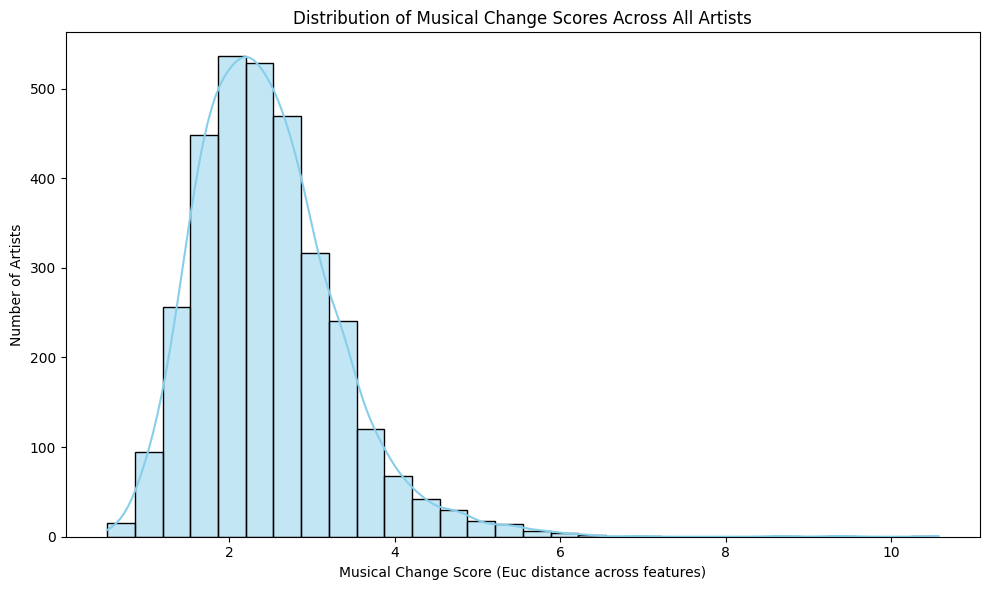

Summary Statistics for Musical Change Score:
count    3213.000000
mean        2.463251
std         0.868762
min         0.522872
25%         1.855700
50%         2.353480
75%         2.928386
max        10.572775
Name: musical_change_score, dtype: float64


In [9]:
# Plot histogram of musical change scores across all artists
plt.figure(figsize=(10, 6))
sns.histplot(
    data=analysis_df,
    x='musical_change_score',
    bins=30,
    kde=True,
    color='skyblue' # chat i thikn we need to come up with a proper color scheme since we need it for poster
)
plt.title('Distribution of Musical Change Scores Across All Artists')
plt.xlabel('Musical Change Score (Euc distance across features)')
plt.ylabel('Number of Artists')
plt.tight_layout()
plt.show()

# Display summary statistics
print('Summary Statistics for Musical Change Score:')
print(analysis_df['musical_change_score'].describe())

### 6.2. Artist Count Per Genre

Before comparing genres, we need to see how many artists we have for each one. Genres with very few artists will not be statistically reliable.

C:\Users\Jervi\AppData\Local\Temp\ipykernel_9236\1410788932.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')


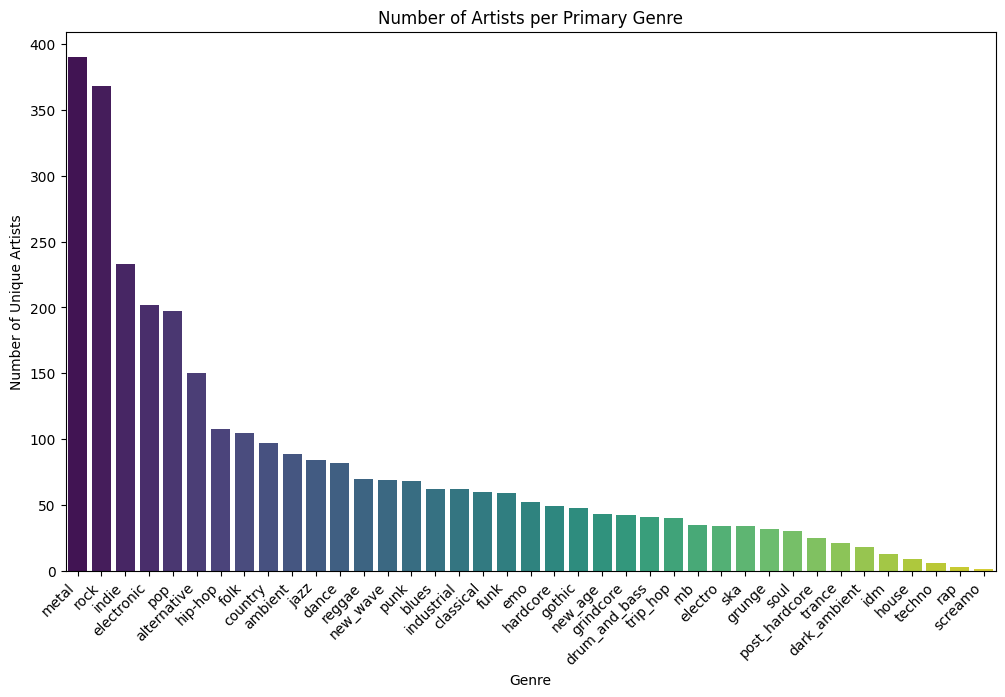

Artist Counts per Genre:
primary_genre
metal            390
rock             368
indie            233
electronic       202
pop              197
alternative      150
hip-hop          108
folk             105
country           97
ambient           89
jazz              84
dance             82
reggae            70
new_wave          69
punk              68
blues             62
industrial        62
classical         60
funk              59
emo               52
hardcore          49
gothic            48
new_age           43
grindcore         42
drum_and_bass     41
trip_hop          40
rnb               35
electro           34
ska               34
grunge            32
soul              30
post_hardcore     25
trance            21
dark_ambient      18
idm               13
house              9
techno             6
rap                3
screamo            1
Name: count, dtype: int64


In [10]:
genre_counts = analysis_df[analysis_df['primary_genre'] != 'Unknown']['primary_genre'].value_counts()

plt.figure(figsize=(12, 7))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Genre')
plt.ylabel("Number of Unique Artists")
plt.title("Number of Artists per Primary Genre")
plt.show()

# Filter for genres with at least 5 artists for meaningful comparison in the next steps
reliable_genres = genre_counts[genre_counts >= 5].index.tolist()
analysis_df_filtered = analysis_df[analysis_df['primary_genre'].isin(reliable_genres)]

# Display the counts as a table
print('Artist Counts per Genre:')
print(genre_counts)

### 6.3. Comparing Musical Change Across Genres

This is the key visualization for our research question. The box plot allows us to compare the distribution of `musical_change_score` for each major genre. We can observe the median change, the spread (IQR), and identify any outliers.

From this, we can start to draw conclusions about which genres tend to see more or less musical evolution among their artists.

C:\Users\Jervi\AppData\Local\Temp\ipykernel_9236\3921089254.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=analysis_df_filtered, x='primary_genre', y='musical_change_score', order=order, palette='BuGn_r')


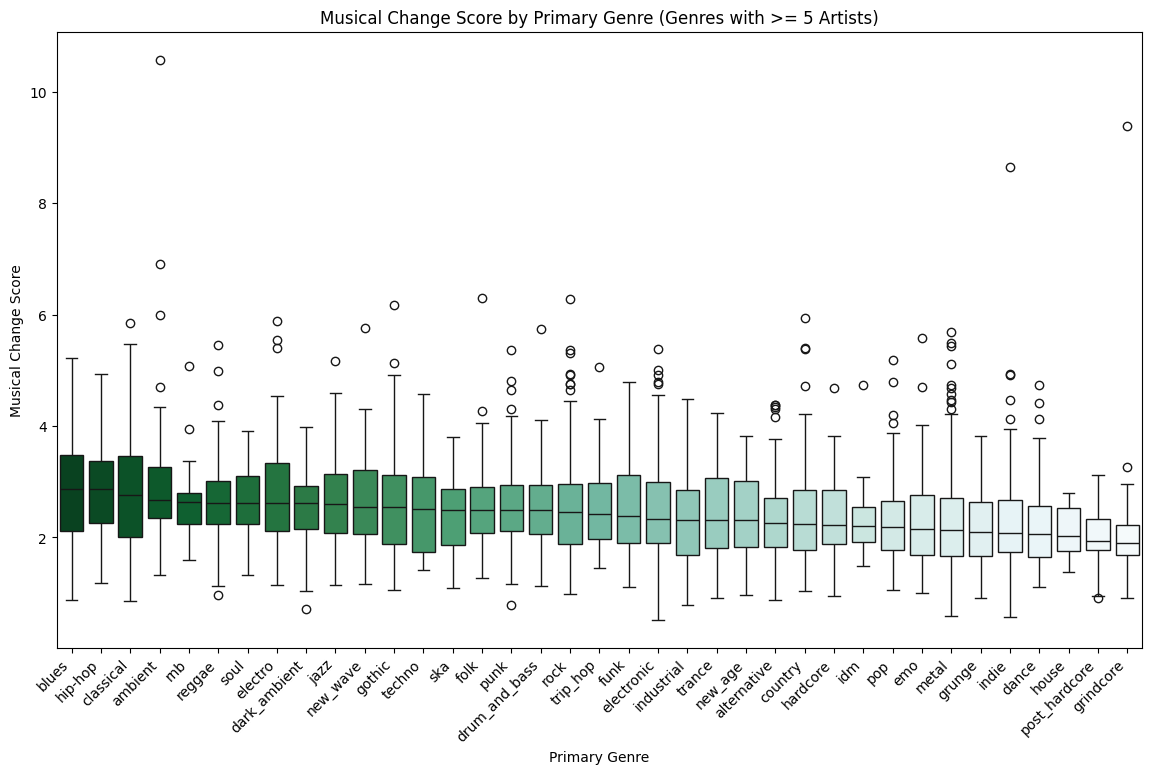

Median and Standard Deviation of Change Score per Genre:
                 median       std
primary_genre                    
blues          2.869923  0.990214
hip-hop        2.862432  0.854259
classical      2.766609  1.068677
ambient        2.675362  1.208991
rnb            2.633992  0.649643
reggae         2.625140  0.856513
soul           2.623886  0.628807
electro        2.621481  1.167709
dark_ambient   2.618055  0.829427
jazz           2.604273  0.812650
new_wave       2.543715  0.801502
gothic         2.538317  1.030610
techno         2.504653  1.182092
ska            2.493046  0.782371
folk           2.487952  0.739064
punk           2.486235  0.851430
drum_and_bass  2.484926  0.816172
rock           2.457868  0.834168
trip_hop       2.413012  0.765128
funk           2.393185  0.796183
electronic     2.337966  0.836819
industrial     2.320539  0.811134
trance         2.308162  0.915379
new_age        2.307734  0.763122
alternative    2.255334  0.703816
country        2.249954  

In [11]:
# NEW EDA 3

plt.figure(figsize=(14, 8))
order = analysis_df_filtered.groupby('primary_genre')['musical_change_score'].median().sort_values(ascending=False).index
sns.boxplot(data=analysis_df_filtered, x='primary_genre', y='musical_change_score', order=order, palette='BuGn_r')
plt.title('Musical Change Score by Primary Genre (Genres with >= 5 Artists)')
plt.xlabel('Primary Genre')
plt.ylabel('Musical Change Score')
plt.xticks(rotation=45, ha='right')
plt.show()

# Display the median and standard deviation for each genre
print('Median and Standard Deviation of Change Score per Genre:')
print(analysis_df_filtered.groupby('primary_genre')['musical_change_score'].agg(['median', 'std']).sort_values('median', ascending=False))

Phase 2
- data mining tech will be clustering with k-means
- stats inference tech will be anova, t-test, and chi square
- insights/conclusions
- poster

Phase 2
- data mining tech will be clustering with k-means
- stats inference tech will be anova, t-test, and chi square
- insights/conclusions
- poster

Data Mining 

clustering

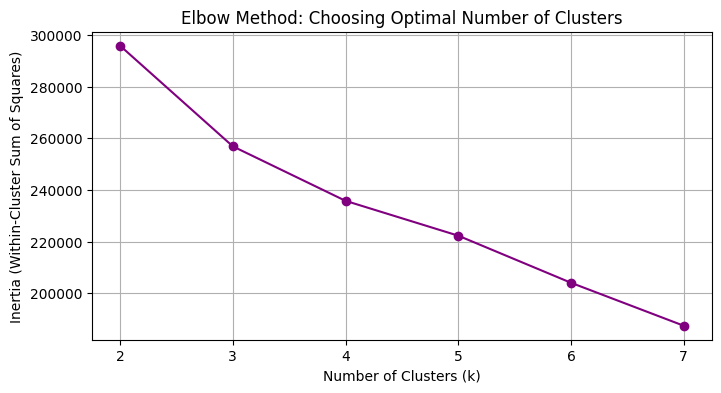

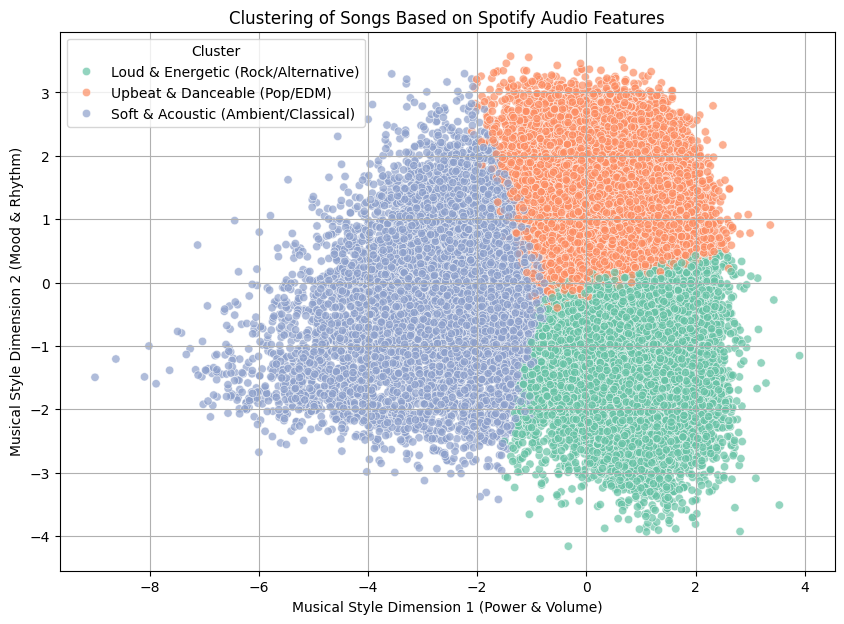

In [12]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define the audio features to use for clustering
audio_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
                  'instrumentalness', 'liveness', 'valence', 'tempo']

# Extract and scale the features from the cleaned dataset
X = df_final[audio_features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine the optimal number of clusters using the Elbow Method
inertia = []
cluster_range = range(2, 8)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(8, 4))
plt.plot(cluster_range, inertia, marker='o', color='purple')
plt.title('Elbow Method: Choosing Optimal Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.grid(True)
plt.show()

# Apply KMeans with k=3 (based on the elbow method result)
kmeans = KMeans(n_clusters=3, random_state=42)
df_final['Cluster_Label'] = kmeans.fit_predict(X_scaled)

# Map the numeric clusters to descriptive labels
cluster_names = {
    0: 'Upbeat & Danceable (Pop/EDM)',
    1: 'Loud & Energetic (Rock/Alternative)',
    2: 'Soft & Acoustic (Ambient/Classical)'
}

df_final['Cluster_Description'] = df_final['Cluster_Label'].map(cluster_names)

# Use PCA to reduce features to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_final['PCA1'] = X_pca[:, 0]
df_final['PCA2'] = X_pca[:, 1]

# Plot the clusters in 2D PCA space
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_final, 
    x='PCA1', 
    y='PCA2', 
    hue='Cluster_Description', 
    palette='Set2', 
    alpha=0.7
)
plt.xlabel('Musical Style Dimension 1 (Power & Volume)')
plt.ylabel('Musical Style Dimension 2 (Mood & Rhythm)')
plt.title('Clustering of Songs Based on Spotify Audio Features')

plt.legend(title='Cluster')
plt.grid(True)
plt.show()


To decide how many clusters (or groups) we should create from the songs, we used something called the Elbow Method. This helps us find the best number of groups by letting us try out different numbers and see how well the songs fit into each one. We tried with creating two to seven groups, seeing how the fit improved with each attempt.  When we initially introduced more groups, the fit significantly improved.  The progress, however, diminished significantly after three groups; it was similar to bending your arm and seeing a sharp "elbow." It's why it's called the Elbow Method. Anyways, that's why we picked 3 clusters. It's because the changes decrease significantly after k = 3.

Interpretion:
Our research question is about change in genre. Here we used musical feautures in "Power & Volume" and "Mood & Rhythm". This is because some genres share similar musical features. 

“Power & Volume” captures the contrast between loud, energetic songs and soft, acoustic ones.
Mood & Rhythm” captures the contrast between happy, danceable tracks and calm, instrumental music

We then link those clusters to each artist’s musical evolution. This will help us answer whether certain types of music are more susceptible to change than others over time.

As you can see above, the songs with soft and acoustic features have lower volume and power. They lie on the negative side of the graph of the x-axis. Genres like classical, ambient, and acoustic folk typically fall here because they rely on soft instrumentation and avoid loud sounds. As for being their mood and rhythm, they all vary as these songs may be fast or slow while varying in their mood. This is because classical and ambient music tend to have low danceability and are often instrumental. This means they lack vocals and steady beats typically found in pop or dance tracks. They may also feauture a more neutral emotional tone compared to pop/rock.

As for the loud/energetic songs, their volume tends to be on the positive side of the x-axis. They also lie on the positive side of the y-axis. This placement is typical of genres like rock, metal, and punk, which are known for their loud style of music. Their mood and rhythm tend to be on the negative side of the y-axis. As for upbeat/danceable songs, they are on the positive side of the x-axis. This is because their emotional tone may be more aggressive, intense, or dark than other genres.

As for the upbeat and danceable songs, they lie on both the positive sides of each axis. These songs are loud while also maintaining a happier mood. Genres like pop, EDM, and dance music commonly fall in this region. They also tend to include vocals focused at upbeat, catchy melodies, and excitement.

Genre Distribution Across Clusters:

yearly_genre                         Unknown  alternative  ambient  blues  \
Cluster_Description                                                         
Loud & Energetic (Rock/Alternative)       96         1046      211    108   
Soft & Acoustic (Ambient/Classical)      217          619      797    343   
Upbeat & Danceable (Pop/EDM)             244         1146      202    392   

yearly_genre                         classical  country  dance  dark_ambient  \
Cluster_Description                                                            
Loud & Energetic (Rock/Alternative)         40      109    133            40   
Soft & Acoustic (Ambient/Classical)        413      235     17           123   
Upbeat & Danceable (Pop/EDM)                25      478    636             4   

yearly_genre                         drum_and_bass  electro  ...  rap  reggae  \
Cluster_Description                                          ...                
Loud & Energet

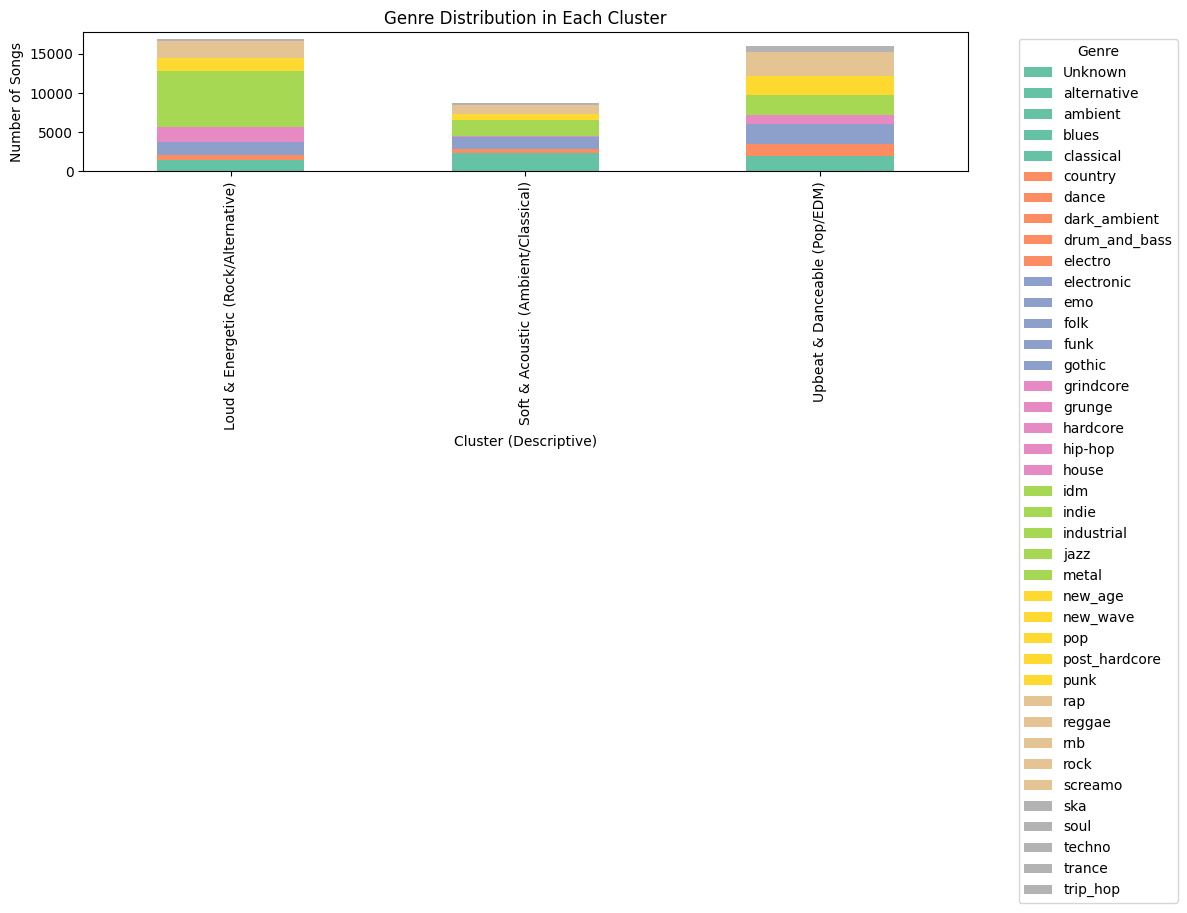

In [15]:
genre_distribution = df_final.groupby('Cluster_Description')['yearly_genre'].value_counts().unstack(fill_value=0)

print("Genre Distribution Across Clusters:\n")
print(genre_distribution)

# We plot the genre distribution as a stacked bar chart
genre_distribution.plot(kind='bar', stacked=True, figsize=(12,6), colormap='Set2')
plt.title('Genre Distribution in Each Cluster')
plt.xlabel('Cluster (Descriptive)')
plt.ylabel('Number of Songs')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [16]:
print("PCA Component 1 Loadings:")
print(dict(zip(audio_features, pca.components_[0])))
print("PCA Component 2 Loadings:")
print(dict(zip(audio_features, pca.components_[1])))

PCA Component 1 Loadings:
{'danceability': np.float64(0.03813551639020469), 'energy': np.float64(0.5516196384882524), 'loudness': np.float64(0.5281507241974236), 'speechiness': np.float64(0.17703498917835125), 'acousticness': np.float64(-0.4942200312924599), 'instrumentalness': np.float64(-0.2010179413670486), 'liveness': np.float64(0.13695637677796646), 'valence': np.float64(0.19929148368811395), 'tempo': np.float64(0.20209177436792158)}
PCA Component 2 Loadings:
{'danceability': np.float64(0.653250551807159), 'energy': np.float64(-0.13302009154146133), 'loudness': np.float64(-0.01933478659857217), 'speechiness': np.float64(-0.0897643591265941), 'acousticness': np.float64(0.10834238162178227), 'instrumentalness': np.float64(-0.3247829728259819), 'liveness': np.float64(-0.23545746331519296), 'valence': np.float64(0.5998441997452253), 'tempo': np.float64(-0.12108908115823133)}


### PCA Axis Interpretation

The PCA loadings help us understand the two dimensions of the 2D cluster plot:

- **PCA Component 1 (X-axis)** is driven by:
  - `energy` (+), `loudness` (+), and `acousticness` (−)
  - This axis distinguishes **energetic, loud songs** from **soft, acoustic ones**

- **PCA Component 2 (Y-axis)** is driven by:
  - `danceability` (+), `valence` (+), and `instrumentalness` (−)
  - This axis captures the contrast between **upbeat, danceable songs** and **instrumental, ambient tracks**

This validates the meaning of our clusters:
- **Cluster: "Upbeat & Danceable"** — top-right quadrant (high energy + danceability)
- **Cluster: "Loud & Energetic"** — far right, lower danceability but very energetic
- **Cluster: "Soft & Acoustic"** — bottom-left quadrant (low energy, high acousticness)


## GENERATIVE AI USE

During the preparation of this work the author(s) used CHATGPT and GOOGLE GEMINI for the following purposes:
- formatting
- proofreading
- aid in understanding concepts
- mental support

After using this tool/service, the author(s) reviewed and edited the content as needed and take(s) full responsibility for the content of the publication.